In [1536]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading the Datasets

In [2556]:
df = pd.DataFrame.from_csv("../data/train_risk.csv", index_col=False)
test = pd.DataFrame.from_csv("../data/test_risk.csv", index_col=False)
X, y = df[df.columns[:-1]], df[df.columns[-1]]

## Analysing the Data

Looking at the difference between the number of positive and negative samples in the dataset shows that there are more negative examples than positive examples. Only 28% of all samples are of the positive class.

In [428]:
def class_balance_summary(y):
    """ Summarise the imbalance in the dataset"""
    total_size = y.size
    negative_class = y[y == 0].size
    positive_class = y[y > 0].size
    ratio = positive_class / float(positive_class + negative_class)

    print "Total number of samples: %d" % total_size
    print "Number of positive samples: %d" % positive_class
    print "Number of negative samples: %d" % negative_class
    print "Ratio of positive to total number of samples: %.2f" % ratio


class_balance_summary(y)

Total number of samples: 300
Number of positive samples: 84
Number of negative samples: 216
Ratio of positive to total number of samples: 0.28


Some initial observations about the data before it is preprocessed:
 - PRE32 is all zeros. This can be removed
 - PRE14 looks catagorical. Should be split into multiple binary variables
 - DGN looks catagorical. As above.
 - PRE5 looks to have some outliers. See box plot below. Potentially remove or split into two extra variable?

In [2391]:
X.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,3,2.08,1.52,1,0,0,0,1,0,4,0,0,0,1,0,49
1,3,4.36,3.76,0,0,0,0,0,0,1,0,0,0,1,0,72
2,3,3.52,2.28,0,0,0,0,0,0,3,0,0,0,1,0,51
3,3,3.36,2.67,1,0,0,0,1,0,1,0,0,0,1,0,72
4,3,3.56,2.80,0,0,0,0,0,0,2,0,0,0,0,0,69


Box plot below shows the outliers in PRE5. It is worth noting that all of these outliers are of the negative class. This variable is the volume that can be exhaled in one second given full inhilation. It is likely that these values are therefore errors in reporting as it is unlikely that humans can exhale such a large volume so quickly.

11     0
25     0
101    0
108    0
122    0
212    0
240    0
Name: Risk1Yr, dtype: int64


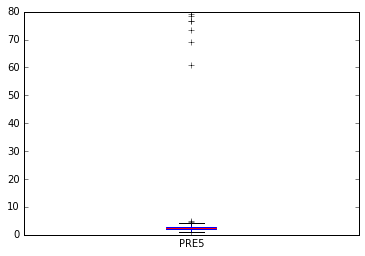

In [3501]:
# X.PRE5.plot(kind='box')
X.PRE5.plot(kind='box')
print y[X.PRE5 > 30 ]

## Preprocessing

Create a new matrix of preprocessed features. This will encode catagorical data as one hot vectors, remove outliers, and normalise the data.  

In [3333]:
from sklearn import preprocessing

def encode_onehot(x_data, column_name, digitize=False):
    """ Encode a catagorical column from a data frame into a data frame of one hot features"""
    data = x_data[[column_name]]

    if digitize:
        data = np.digitize(data, np.arange(data.min(), data.max(), 10))
    
    enc = preprocessing.OneHotEncoder()
    features = enc.fit_transform(data).toarray()
    names = ['%s_%d' % (column_name, i) for i in enc.active_features_]
    features = pd.DataFrame(features, columns=names, index=x_data.index)
    return features


def preprocess(x_data, y_data):
    # drop zero var PRE32
    Xp = x_data.drop("PRE32", axis=1)
    
    # remove outliers
    mask = Xp.PRE5 < 30  
    Yp = y_data.copy()
    Xp = Xp.loc[mask]
    Yp = Yp.loc[mask]
    
    # encode catagorical data as one hot vectors
    one_hot_names = ["DGN"]
    encoded = map(lambda name: encode_onehot(Xp, name), one_hot_names)
    #combine into a single data frame
    new_features = pd.concat(encoded, axis=1)

    # drop the catagorical variables that have been encoded
    Xp.drop(["DGN"], inplace=True, axis=1)
    # add new features
    Xp = pd.concat([Xp, new_features], axis=1)

    return Xp, Yp

Xp, Yp = preprocess(X, y)
Xp.head()

,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,...,PRE45_0,PRE45_1,PRE45_2,DGN_1,DGN_2,DGN_3,DGN_4,DGN_5,DGN_6,DGN_8
0,2.08,1.52,1,0,0,0,1,0,4,0,...,2.08,1.52,3.1616,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.36,3.76,0,0,0,0,0,0,1,0,...,4.36,3.76,16.3936,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.52,2.28,0,0,0,0,0,0,3,0,...,3.52,2.28,8.0256,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.36,2.67,1,0,0,0,1,0,1,0,...,3.36,2.67,8.9712,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.56,2.80,0,0,0,0,0,0,2,0,...,3.56,2.80,9.9680,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Measure the effectiveness of each feature using the variable importance measure from a Random Forest

FER        0.121839
PRE45_0    0.110721
AGE        0.107024
PRE4       0.093969
PRE45_2    0.092654
PRE5       0.091806
PRE45_1    0.090610
PRE14      0.043051
DGN_5      0.032862
PRE30      0.028693
PRE10      0.026337
PRE6       0.023660
DGN_4      0.020996
PRE8       0.019564
PRE9       0.017372
DGN_3      0.016724
DGN_2      0.015028
PRE11      0.014843
OBS        0.010222
PRE7       0.008893
PRE17      0.004037
DGN_8      0.003648
PRE19      0.002546
PRE25      0.002262
DGN_1      0.000640
DGN_6      0.000000
dtype: float64

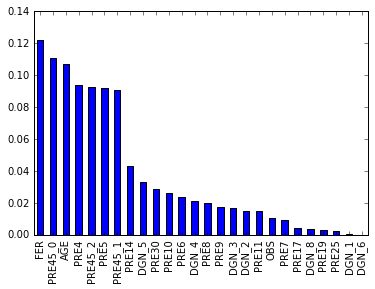

In [3496]:
def measure_importance(x_data, y_data):
    rf_selector = RandomForestClassifier(criterion='gini', class_weight='balanced')
    rf_selector.fit(scaler.fit_transform(x_data), y_data)
    feature_importance = pd.Series(rf_selector.feature_importances_, index=Xp.columns).sort_values(ascending=False)
    feature_importance.plot(kind='bar')
    return feature_importance

measure_importance(Xp, Yp)
# Xp.drop(feature_importance[feature_importance == 0].index, inplace=True, axis=1)

The numerical features appear to be the most important ones. Plot a scatter plot matrix to see how the how the correlate with each other

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0d4cb10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x17424e610>]], dtype=object)

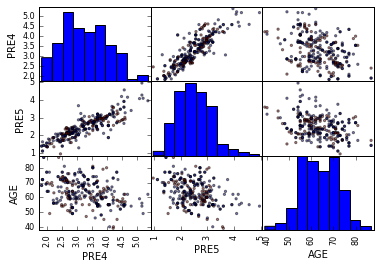

In [3498]:
pd.tools.plotting.scatter_matrix(Xp[['PRE4', 'PRE5', 'AGE']], c=Yp)

## Tuning Model Parameters

Given the current status of the data tune the model parameters to it before we evalute the overall performance. 

In [3532]:
from sklearn import cross_validation
skf = cross_validation.StratifiedKFold(Yp, n_folds=5)

### Random Forest Tuning
Run a grid search over a range of parameters for a Random Forest. The dataset is small enough that we can do them all at once. ```n_estimators``` is neglected because this should always improve as it is increased so we should attempt to make it as large as possible subject to lack of improvement

In [3554]:
param_grid = {"max_depth": range(1, 20, 3),
              "max_features": range(1, 20, 3),
              "min_samples_split": range(1, 5),
              "min_samples_leaf": range(1, 5),
             }

rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=50)
rf_clf = grid_search.GridSearchCV(rf, param_grid, n_jobs=-1, cv=skf, scoring='roc_auc')
rf_clf.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 4, 7, 10, 13, 16, 19], 'min_samples_split': [1, 2, 3, 4], 'max_depth': [1, 4, 7, 10, 13, 16, 19], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [3560]:
print rf_clf.best_params_

{'max_features': 1, 'min_samples_split': 1, 'max_depth': 16, 'min_samples_leaf': 1}


Now take a look at the number of estimators and see where performance begins to level off.

In [3561]:
param_grid = {"n_estimators": range(50, 500, 50)}
const_params = {'max_features': 1, 'min_samples_split': 1, 'max_depth': 16, 'min_samples_leaf': 1}

rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=50, **const_params)
rf_clf2 = grid_search.GridSearchCV(rf, param_grid, n_jobs=-1, cv=skf, scoring='roc_auc')
rf_clf2.fit(Xp, Yp)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features=1,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

The best parameters for ```n_estimators``` levels off after around 300 estimators

{'n_estimators': 300}


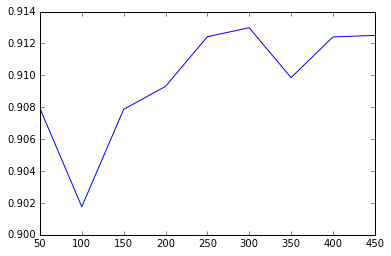

In [3565]:
plt.plot([d[0]['n_estimators'] for d in rf_clf2.grid_scores_], [d[1] for d in rf_clf2.grid_scores_])
print rf_clf2.best_params_

### Gradient Boosting Tuning

Gradient boosting is difficult to tune effectively. [This guide](http://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) suggests starting by fixing the learning rate and number of estimators to a relatively low number in order to tune the other hyperparameters. After they are optimised the learning rate is gradually lowered and the number of estimators increased until we find convergance on the optimum parameters

In [ ]:
param_grid = [
   {'learning_rate': [0.1], 'n_estimators': range(20,81,10)}
]

const_params = {'min_samples_split': 1, 'min_samples_leaf': 3, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8}
gbc = GradientBoostingClassifier(**const_params)

gbc_clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
gbc_clf.fit(Xp, Yp)

In [ ]:
print gbc_clf.best_params_

In [ ]:
const_params = {'n_estimators':80, 'learning_rate': 0.1, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'subsample': 0.8}
gbc = GradientBoostingClassifier(**const_params)

param_grid = [
    {'max_depth':range(5,16,2), 'min_samples_split':range(1, 20, 3)}
 ]

skf = cross_validation.StratifiedKFold(Yp, n_folds=5)
clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
clf.fit(Xp, Yp)
print clf.best_params_
clf.grid_scores_

In [ ]:

const_params = {'n_estimators':1000, 'learning_rate': 0.001, 'min_samples_leaf': 3, 'min_samples_split':3, 'max_depth':9, 'max_features': 'sqrt', 'subsample': 0.8}
gbc = GradientBoostingClassifier(**const_params)

cross_validation.cross_val_score(gbc, Xp, Yp, scoring='roc_auc', cv=skf).mean()

### AdaBoost Tuning

### Extremely Random Trees Tuning

## Model Performance
Test the performance of each of the models on the preprocessed dataset before trying any more complicated feature engineering/resampling. This should give us some rough baseline AUC measures to work with. Firstly, set up the models. This creates a set of pipelines for each of the models we want to use. 

In [3567]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
reload(pipeline)
import pipeline
reload(roc_analysis)
from roc_analysis import ROCAnalysisScorer

scaler = preprocessing.StandardScaler()

# set up classifier objects
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
dct = DecisionTreeClassifier(max_depth=4)
abt = AdaBoostClassifier(dct, n_estimators=400)

gbc_params = {'n_estimators':1600, 'learning_rate': 0.005, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'subsample': 0.8, 'min_samples_split': 4, 'max_depth': 13}
gbc = GradientBoostingClassifier(**gbc_params)

rf_common_params = {'n_estimators':300, 'max_features':16, 'criterion':'entropy'}
exf = ExtraTreesClassifier( class_weight="balanced", **rf_common_params)
rf_balanced = RandomForestClassifier(class_weight='balanced_subsample', **rf_common_params)

# create pipelines for each model
abt_pipe = Pipeline([('scaler', scaler), ('AdaBoost', abt)])
exf_pipe = Pipeline([('scaler', scaler), ('ExtraTrees', exf)])
gbc_pipe = Pipeline([('scaler', scaler), ('GradientBoostingClassifer', gbc)])
rfs_pipe = Pipeline([('scaler', scaler), ('RandomForest', rf_balanced)])

# create list of model data
models = [
#     {'name': 'AdaBoost', 'model': abt_pipe},
#     {'name': 'ExtraTrees', 'model': exf_pipe},
    {'name': 'RandomForest', 'model': rfs_pipe},
#     {'name': 'GradientBoost', 'model': gbc_pipe},
]

# set the same training set for all models.
# this is just the preprocessed dataset.
for model in models:
    model['train_data'] = (Xp, Yp)

Define some useful helper functions for summarising the results of k-fold/monte carlo cross validation

In [3500]:
def f_score_summary(scorers):
    """ Create a summary of the average f-scores for all folds/trials"""
    series = []
    columns = []
    for key, scorer in scorers.iteritems():
        f_scores = [np.mean(scorer.f1scores_), np.mean(scorer.f2scores_), np.mean(scorer.fhalf_scores_)]
        s = pd.Series(f_scores, index=['F1', 'F2', 'F0.5'])
        series.append(s)
        columns.append(key)
    
    frame = pd.concat(series, axis = 1)    
    frame.columns = columns
    return frame

def summarise_scorers(scoeres):
    """ Create a summary of the scorers AUCs for all folds/trials"""
    names = [name for name in scorers.keys()]
    aucs = [scorer.aucs_ for scorer in scorers.values()]
    aucs = pd.DataFrame(np.array(aucs).T, columns=names)
    return aucs.describe()

Perform n iterations of k fold cross validation. Here I am using 10 iterations and 5 folds at each iteration.

In [3568]:
scorers = pipeline.repeated_cross_fold_validation(models, n=10, k=5)

Plot an ROC curve and the mean AUCs.

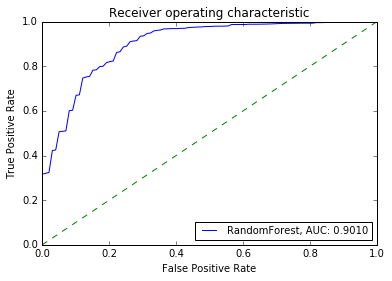

In [3569]:
%matplotlib inline
for key, scorer in scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), '--')
# plt.savefig("img/roc_cv.png")

Plot bar chart of the F2 scores

In [ ]:
ax = f_scores.loc['F2'].plot(kind='barh', title='F2 Measure for All Classifiers', color=['b', 'r', 'g', 'y'])
ax.set_xlabel('F2 Score')
plt.tight_layout()
plt.savefig('img/f2_score.png')

Summarise the F scores

In [3499]:
f_scores = f_score_summary(scorers)
print f_scores.to_latex()
f_scores

\begin{tabular}{lrrrr}
\toprule
{} &  RandomForest &  ExtraTrees &  GradientBoost &  AdaBoost \\
\midrule
F1   &      0.557502 &    0.643371 &       0.582411 &  0.617863 \\
F2   &      0.478619 &    0.589029 &       0.515569 &  0.562853 \\
F0.5 &      0.681112 &    0.715311 &       0.676343 &  0.689950 \\
\bottomrule
\end{tabular}



,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.557502,0.643371,0.582411,0.617863
F2,0.478619,0.589029,0.515569,0.562853
F0.5,0.681112,0.715311,0.676343,0.689950


## Feature Engineering

Test creating some new features based on combinations of existing ones in the dataset. Cross validate each set of new features to see if it improves performance.

### Binary Features

In [3224]:
import itertools

def binary_combinations(x_data, names):
    name_pairs = itertools.combinations(names, 2)
    features = []
    for a_name, b_name in name_pairs:
        a, b = x_data[a_name], x_data[b_name]
        features.append(np.logical_xor(a, b).astype(int))
        features.append(np.logical_and(a, b).astype(int))
        features.append(np.logical_or(a, b).astype(int))
        
    return pd.DataFrame(np.array(features).T, index=x_data.index)

binary_features = binary_combinations(Xp, ['PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE17', 'PRE30'])
Xp = pd.concat([Xp, binary_features], axis=1)

### Spirometry Based Features

In [ ]:
# create new feature FER
# this is the raito of FEV1 and FVC
Xp['FER'] = (Xp.PRE5 / Xp.PRE4) * 100

# create a new feature OBS
# this is whether the instance has a FER below 70%
# which implies an obstructive disease.
Xp['OBS'] = np.zeros(Xp.AGE.shape)
Xp.OBS.loc[Xp.FER < 70] = 1.0

### Polynomial Combinations

In [ ]:
def create_poly_features(x_data, names):
    # create new features base on Polynomials of the original best two predictors
    poly = sklearn.preprocessing.PolynomialFeatures(2, include_bias=False, interaction_only=True)
    poly_features = pd.DataFrame(poly.fit_transform(x_data[names]), index=x_data.index)
    poly_features.columns = ["POLY_%d" % i for i in poly_features.columns]
    return poly_features

poly_features = create_poly_features(Xp, ['PRE4', 'PRE5'])
Xp = pd.concat([Xp, poly_features], axis=1)

## Resampling the Dataset

Testing whether using resampling improves performance

### Testing with regular Over/Under sampling

In [3489]:
splitter = pipeline.OverUnderSplitter(test_size=0.2, under_sample=0.4, over_sample=0.8)
overunder_scorers = pipeline.monte_carlo_validation(Xp, Yp, models, splitter, n=50)

Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Over-sampling performed: Counter({0: 167, 1: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 120}
Under-sampling performed: Counter({1: 120, 0: 48})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Over-sampling performed: Counter({0: 167, 1: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 120}
Under-sampling performed: Counter({1: 120, 0: 48})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Over-sampling performed: Counter({0: 167, 1: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 120}
Under-sampling performed: Counter({1: 120, 0: 48})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Over-sampling performed: Counter({0: 167, 1: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 120}
Under-sampling performed: Counter({1: 120, 0: 48})
Determining classes statisti

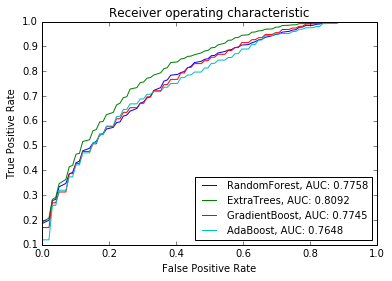

In [3490]:
for key, scorer in overunder_scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

In [3485]:
f_score_summary(overunder_scorers)

,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.548745,0.583188,0.546389,0.549007
F2,0.695434,0.704861,0.675865,0.658299
F0.5,0.454072,0.498930,0.459672,0.472353


In [3398]:
summarise_scorers(smote_scorers)

,RandomForest
count,50.000000
mean,0.898258
std,0.042592
min,0.813025
25%,0.865721
50%,0.905869
75%,0.934174
max,0.964986


### Testing with SMOTE + Undersampling

In [3491]:
smote_params = {'kind': 'regular', 'k':3, 'ratio': 0.8, 'verbose': 1}
splitter = pipeline.SMOTESplitter(test_size=0.2, under_sample=1.0, smote_params=smote_params)
smote_scorers = pipeline.monte_carlo_validation(Xp, Yp, models, splitter, n=50)

Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 53 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 167, 1.0: 120}
Under-sampling performed: Counter({0.0: 120, 1.0: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 53 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 167, 1.0: 120}
Under-sampling performed: Counter({0.0: 120, 1.0: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 53 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 167, 1.0: 120}
Under-sampling performed: Counter({0.0: 120, 1.0: 120})
Determining classes statistics... 2 classes detected: {0: 167, 1: 67}
Finding the 

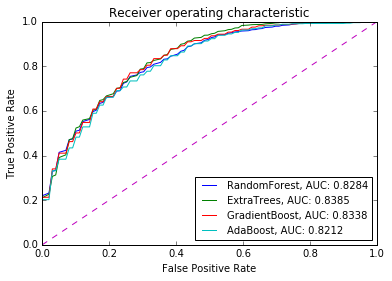

In [3492]:
for key, scorer in smote_scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)
    
plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), '--')
plt.savefig("img/roc_smote.png")

In [3493]:
smote_f_scores = f_score_summary(smote_scorers)
print smote_f_scores.to_latex()
smote_f_scores

\begin{tabular}{lrrrr}
\toprule
{} &  RandomForest &  ExtraTrees &  GradientBoost &  AdaBoost \\
\midrule
F1   &      0.608050 &    0.607756 &       0.613770 &  0.606394 \\
F2   &      0.630137 &    0.644210 &       0.640147 &  0.642141 \\
F0.5 &      0.592520 &    0.578812 &       0.594403 &  0.578318 \\
\bottomrule
\end{tabular}



,RandomForest,ExtraTrees,GradientBoost,AdaBoost
F1,0.608050,0.607756,0.613770,0.606394
F2,0.630137,0.644210,0.640147,0.642141
F0.5,0.592520,0.578812,0.594403,0.578318


## Predicton on Test Set

Finally, based on the best combination of techniques used in the preceeding sections, and using the classifier with the best AUC performance, make probalistic predictions based on the unlabelled test data.